## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Polygon
import calibration
import helpers
import threshold
import warp
import lines
import draw
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Camera Calibration using chessboard images

In [2]:
images = glob.glob('./camera_cal/calibration*.jpg')

In [3]:
mtx, dist = calibration.camera_calibration(images, 6, 9)

## Undistorted chessboard Image

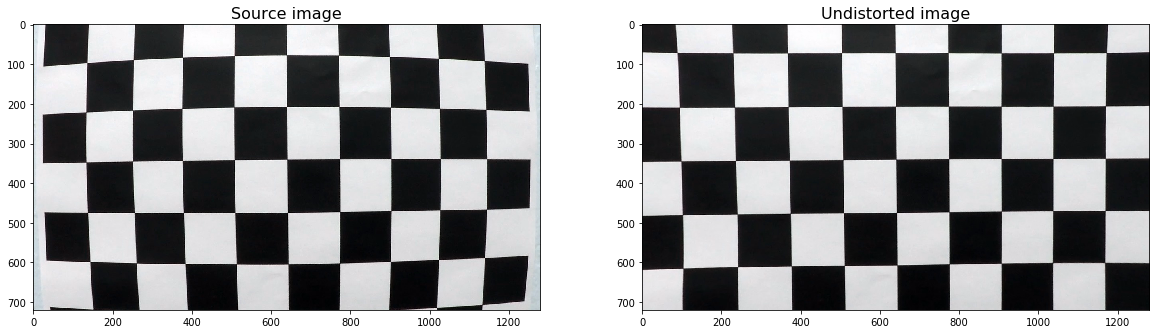

In [4]:
img = cv2.imread('./camera_cal/calibration1.jpg')
undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    
helpers.plt_images(img, 'Source image', undistorted_img, 'Undistorted image')

## Create a thresholded binary image

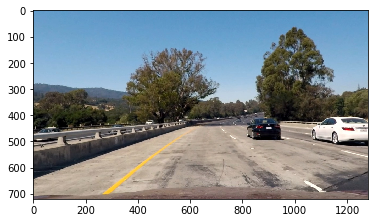

In [5]:
image = cv2.imread('./test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.undistort(image, mtx, dist, None, mtx)

plt.imshow(image)

### 1- Directional gradient

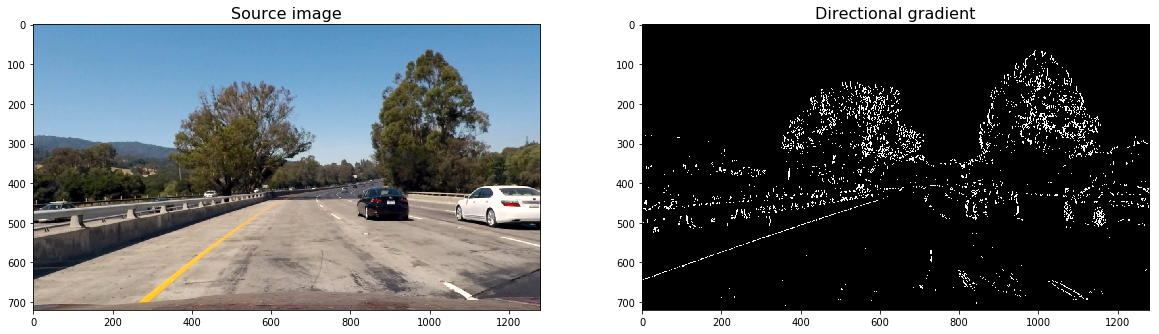

In [6]:
grad_x = threshold.abs_sobel_thresh(image, orient='x', thresh=(30, 100))
helpers.plt_images(image, 'Source image', grad_x, 'Directional gradient')

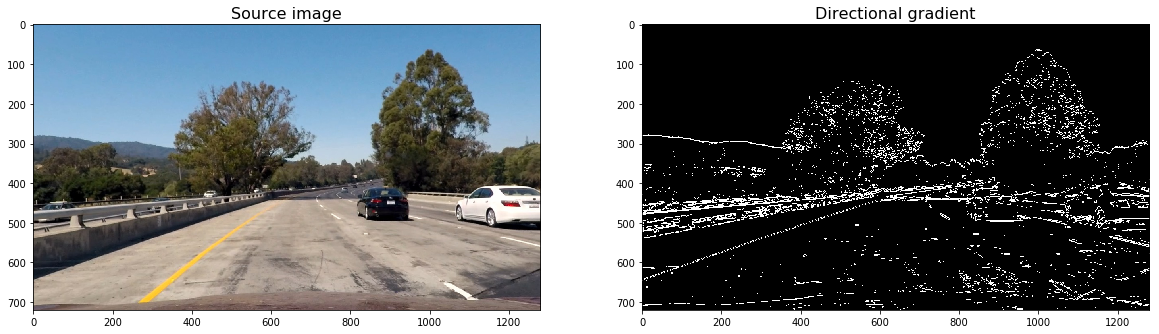

In [7]:
grad_y = threshold.abs_sobel_thresh(image, orient='y', thresh=(30, 100))
helpers.plt_images(image, 'Source image', grad_y, 'Directional gradient')

### 2- Gradient magnitude

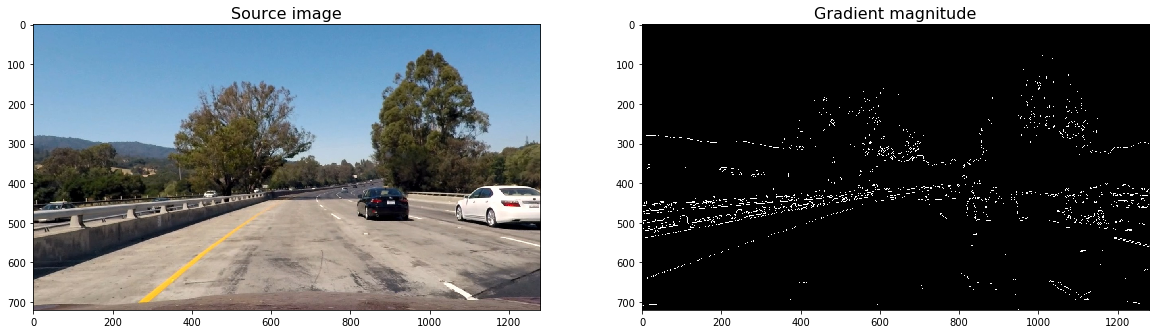

In [8]:
mag_binary = threshold.mag_thresh(image, sobel_kernel=3, thresh=(70, 100))
helpers.plt_images(image, 'Source image', mag_binary, 'Gradient magnitude')

### 3- Gradient direction

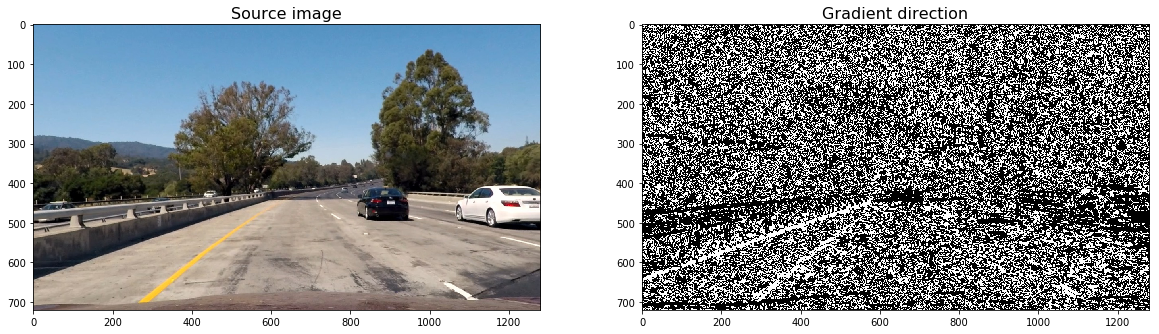

In [ ]:
dir_binary = threshold.dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
helpers.plt_images(image, 'Source image', dir_binary, 'Gradient direction')

### 4- Color threshold

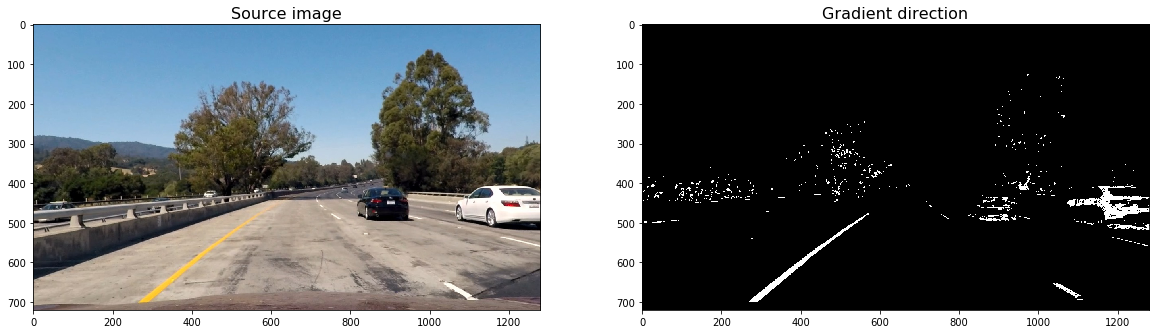

In [ ]:
col_binary = threshold.col_thresh(image, thresh=(170, 255))
helpers.plt_images(image, 'Source image', col_binary, 'Gradient direction')

### 5- Combined thresholds

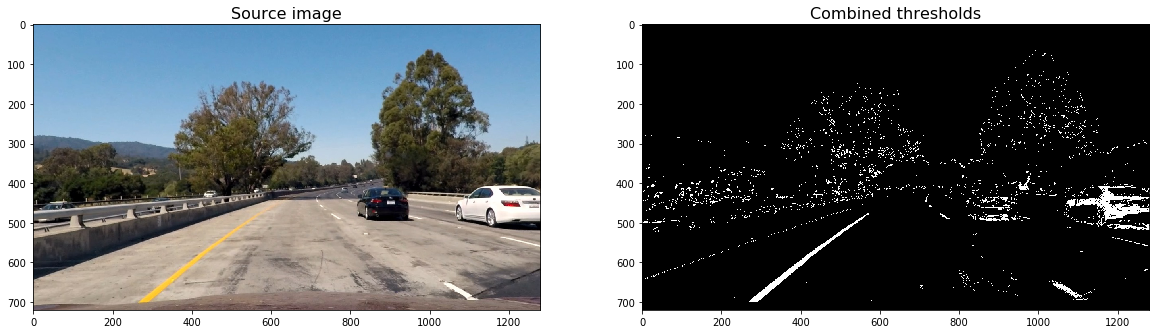

In [ ]:
combined = threshold.combine_threshs(grad_x, grad_y, mag_binary, dir_binary, col_binary, ksize=15)
helpers.plt_images(image, 'Source image', combined, 'Combined thresholds')

## Apply a perspective transform to rectify binary image ("birds-eye view")

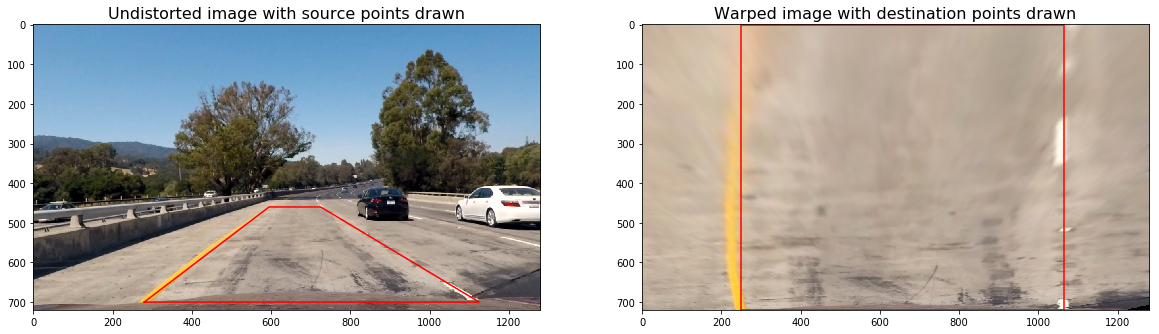

In [ ]:
src_coordinates = np.float32(
    [[280,  700],  # Bottom left
     [595,  460],  # Top left
     [725,  460],  # Top right
     [1125, 700]]) # Bottom right

dst_coordinates = np.float32(
    [[250,  720],  # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]]) # Bottom right 

warped_img, _ , Minv  = warp.warp(image, src_coordinates, dst_coordinates)
# Visualize undirstorsion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted image with source points drawn', fontsize=16)
ax1.plot(Polygon(src_coordinates).get_xy()[:, 0], Polygon(src_coordinates).get_xy()[:, 1], color='red')
ax1.imshow(image)

ax2.set_title('Warped image with destination points drawn', fontsize=16)
ax2.plot(Polygon(dst_coordinates).get_xy()[:, 0], Polygon(dst_coordinates).get_xy()[:, 1], color='red')
ax2.imshow(warped_img)

## Detect lane pixels and fit to find the lane boundary

### Create Histogram

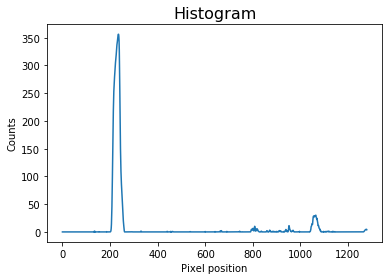

In [ ]:
# Run de function over the combined warped image
combined_warped = warp.warp(combined)[0]
histogram = helpers.get_histogram(combined_warped)

# Plot the results
plt.title('Histogram', fontsize=16)
plt.xlabel('Pixel position')
plt.ylabel('Counts')
plt.plot(histogram)

### Detect Lines

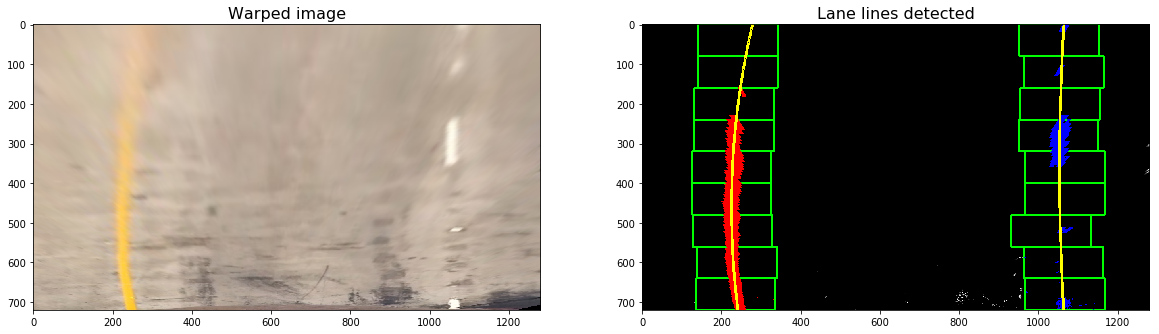

In [ ]:
lines_fit, left_points, right_points, out_img = lines.detect_lines(combined_warped, return_img=True)
helpers.plt_images(warped_img, 'Warped image', out_img, 'Lane lines detected')

### Detect Similar Lines

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


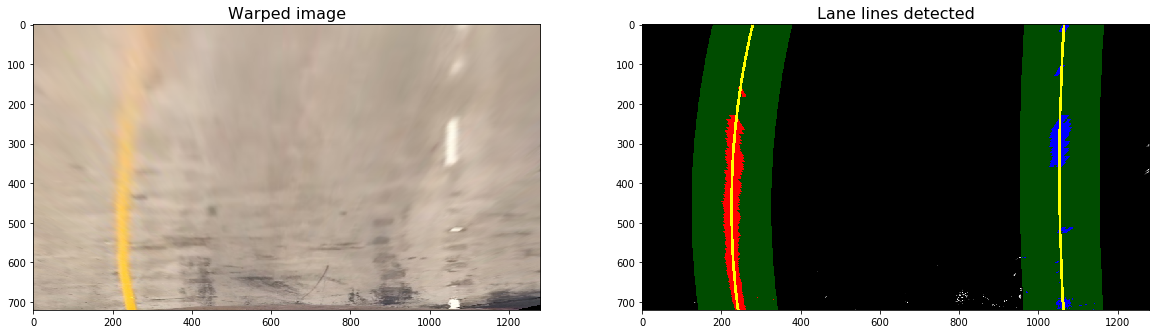

In [ ]:
lines_fit, left_points, right_points, out_img = lines.detect_similar_lines(combined_warped, lines_fit, return_img=True)
helpers.plt_images(warped_img, 'Warped image', out_img, 'Lane lines detected')


## Determine the curvature of the lane and vehicle position with respect to center

### Calculate Curvature Radius

In [ ]:
curvature_rads = lines.curvature_radius(leftx=left_points[0], rightx=right_points[0], img_shape = img.shape)
print('Left line curvature:', curvature_rads[0], 'm')
print('Right line curvature:', curvature_rads[1], 'm')

Left line curvature: 518.4476261684651 m
Right line curvature: 1558.810189537155 m


### Calculate Car Offset

In [ ]:
offsetx = lines.car_offset(leftx=left_points[0], rightx=right_points[0], img_shape=img.shape)
print ('Car offset from center:', offsetx, 'm.')

Car offset from center: -0.0560041662700661 m.


## Warp the detected lane boundaries back onto the original image

### Draw Lane

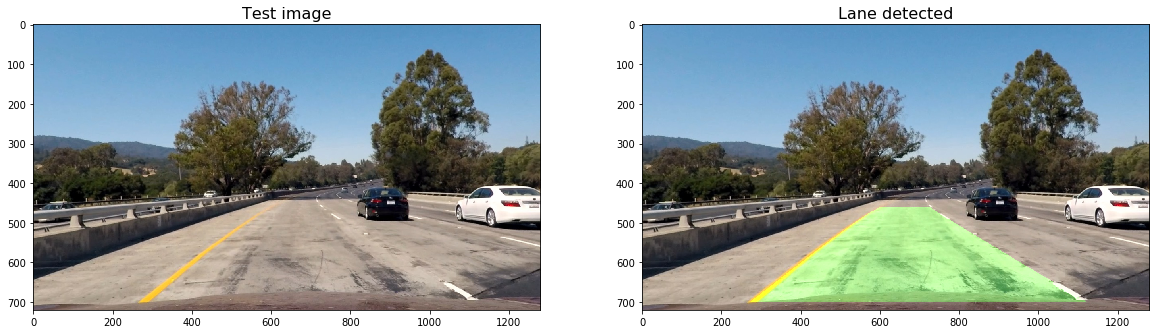

In [ ]:
img_lane = draw.draw_lane(image, combined_warped, left_points, right_points, Minv)
helpers.plt_images(image, 'Test image', img_lane, 'Lane detected')

### Add Metrics

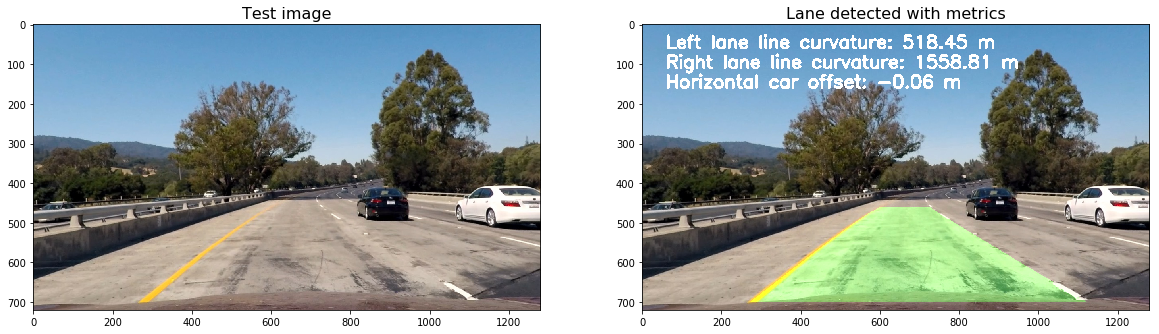

In [ ]:
out_img = draw.add_metrics(img_lane, leftx=left_points[0], rightx=right_points[0])
helpers.plt_images(image, 'Test image', out_img, 'Lane detected with metrics')

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position video

In [ ]:
class Pipeline:
    def __init__(self, images):
        # Make a list of calibration images
        images = glob.glob(images)

        # Calibrate camera
        self.mtx, self.dist = calibration.camera_calibration(images, 6, 9)
        self.lines_fit = None

    def __call__(self, img):
        # Undistord image
        img = cv2.undistort(img, mtx, dist, None, mtx)

        # Calculate directional gradient
        grad_binary = threshold.abs_sobel_thresh(img, orient='x', sobel_kernel=15, thresh=(30, 100))

        # Calculate gradient magnitude 
        mag_binary = threshold.mag_thresh(img, sobel_kernel=15, thresh=(50, 100))

        # Calculate gradient direction
        dir_binary = threshold.dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

        # Calculate color threshold
        col_binary = threshold.col_thresh(img, thresh=(170, 255))

        # Combine all the thresholds to identify the lane lines
        combined = threshold.combine_threshs(grad_x, grad_y, mag_binary, dir_binary, col_binary, ksize=15)

        # Apply a perspective transform to rectify binary image ("birds-eye view")
        src_coordinates = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right

        dst_coordinates = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right   

        combined_warped, _, Minv = warp.warp(combined, src_coordinates, dst_coordinates)
                
        self.lines_fit, left_points, right_points, out_img = lines.detect_similar_lines(combined_warped, self.lines_fit, return_img=True)

        # Warp the detected lane boundaries back onto the original image.
        img_lane = draw.draw_lane(img, combined_warped, left_points, right_points, Minv)
            
        # Add metrics to the output img
        out_img = draw.add_metrics(img_lane, leftx=left_points[0], rightx=right_points[0])
            
        return out_img

In [ ]:
input_video = './project_video.mp4'
output_video = './project_video_solution.mp4'

clip1 = VideoFileClip(input_video)
process_image = Pipeline('./camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./project_video_solution.mp4.
Moviepy - Writing video ./project_video_solution.mp4



t:  70%|███████   | 886/1260 [03:46<01:36,  3.86it/s, now=None]

In [ ]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))